# Sterbetafeln im Zeitalter von "Data Science"

Vortrag für die Generalversammlung der AVÖ

    17. Mai 2018

## Technische Vorbereitungen

### Import von Programmbibliotheken

In [1]:
# "Standard" Bibliotheken
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import uniform, norm
from pandas_datareader import data
from scipy.fftpack import rfft, irfft, fft, rfft, dct, idct
from scipy.cluster.vq import kmeans2 as kmeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale as scale_this
%matplotlib inline

### Pfade und Konstante

In [2]:
# !!! DIE FOLGENDEN PFADNAMEN MÜSSTEN AN LOKALE GEGEBENHEITEN ANGEPASST WERDEN !!!
# Daten vom statistischen Bundesamt Deutschland: 
DATAPATH = '/Users/mfulmek/Work/Brotberuf/Vortraege/AVOE2018/destatis/'
# Graphiken:
GRAPHPATH = '/Users/mfulmek/Work/Brotberuf/Vortraege/AVOE2018/graphics/'

## Datenanalyse

### Leicht (und kostenlos;-) zugängliche Rohdaten

Das deutsche Bundesamt für Statistik stellt unter dem Link https://www-genesis.destatis.de/genesis/online/logon?language=de&sequenz=tabelleErgebnis&selectionname=12613-0003&zeitscheiben=5 eine Tabelle der Todesfälle in Deutschland für die Jahre 2011-2015 zur Verfügung, gegliedert nach Geschlecht und Lebensjahr: Ich habe das entsprechende Datenfile (12613-0003.xlsx) heruntergeladen und kann es nun einlesen.

In [3]:
GD = pd.read_excel(DATAPATH+'12613-0003.xlsx')

In [4]:
# Die ersten 6 Datenzeilen
GD[:6]

Gestorbene: Deutschland, Jahre, Geschlecht, Altersjahre  Unnamed: 1  \
0                          Statistik der Sterbefälle              NaN   
1                                        Deutschland              NaN   
2                                Gestorbene (Anzahl)              NaN   
3                            Geschlecht\nAltersjahre           2011.0   
4                                           männlich              NaN   
5                                       unter 1 Jahr           1347.0   

   Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  
0         NaN         NaN         NaN         NaN  
1         NaN         NaN         NaN         NaN  
2         NaN         NaN         NaN         NaN  
3      2012.0      2013.0      2014.0      2015.0  
4         NaN         NaN         NaN         NaN  
5      1207.0      1268.0      1266.0      1297.0

In [5]:
# Die Datenzeilen 105 bis 109
GD[105:110]

Gestorbene: Deutschland, Jahre, Geschlecht, Altersjahre  Unnamed: 1  \
105                                 100 Jahre und mehr            846.0   
106                                    Alter unbekannt              0.0   
107                                          Insgesamt         407628.0   
108                                           weiblich              NaN   
109                                       unter 1 Jahr           1061.0   

     Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  
105       886.0      1066.0      1006.0      1082.0  
106         0.0         0.0         0.0         0.0  
107    416423.0    429645.0    422225.0    449512.0  
108         NaN         NaN         NaN         NaN  
109       995.0       982.0      1018.0      1108.0

In [6]:
# Die Datenzeilen 208 und 209
GD[208:210]

Gestorbene: Deutschland, Jahre, Geschlecht, Altersjahre  Unnamed: 1  \
208                                         99-Jährige           3394.0   
209                                 100 Jahre und mehr           5746.0   

     Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  
208      3560.0      3586.0      3208.0      2377.0  
209      6146.0      6356.0      6476.0      6793.0

In [7]:
# Trennen der Kollektive: Todesfälle Männer/Frauen in Deutschland
GMD = GD[5:106] # Zeilen entsprechend Todesfälle Männer
GFD = GD[109:210] # Zeilen entsprechend Todesfälle Frauen

In [8]:
# Überflüssige Informationen entfernen, Spaltenüberschriften = Jahre 2011 bis 2015
COLUMNS = [str(year) for year in range(2011,2016)]
GMD = pd.DataFrame(GMD.values[:,1:], columns=COLUMNS)
GFD = pd.DataFrame(GFD.values[:,1:], columns=COLUMNS)

## Erster Schritt: Visualisierung!

In [9]:
# "Interne Buchhaltung" für unsere Daten:
DATEN = {
    'm' : {
        'bez' : 'Männer',
        'roh' : GMD
    },
    'f' : {
        'bez' : 'Frauen',
        'roh' : GFD
    }
}

In [10]:
# Hilfsfunktion zum Plotten der Rohdaten:
def rohdaten_plot(gender):
    """Hilfsfunktion: Plot der Todesfall-Rohdaten für Männer ('m') oder Frauen ('f')"""
    myplot = DATEN[gender]['roh'].plot(
        title=f'Todesfälle: {DATEN[gender]["bez"]} in Deutschland, 2011-2015', figsize=(12,8)
    )
    myplot.set_xlabel('Alter')
    myplot.set_ylabel('Anzahl Todesfälle')
    myplot.grid(b=True)
    plt.xticks(np.arange(0, 101, 5))
    plt.savefig(GRAPHPATH+f'roh_{gender}.eps')
    return myplot

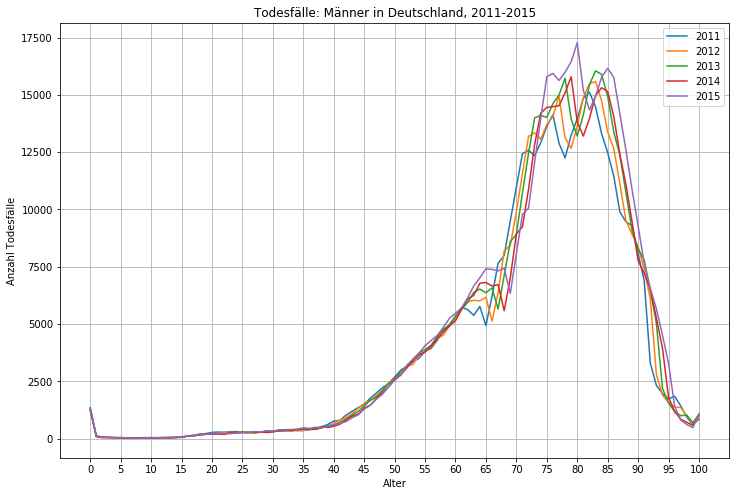

In [11]:
rohdaten_plot('m')

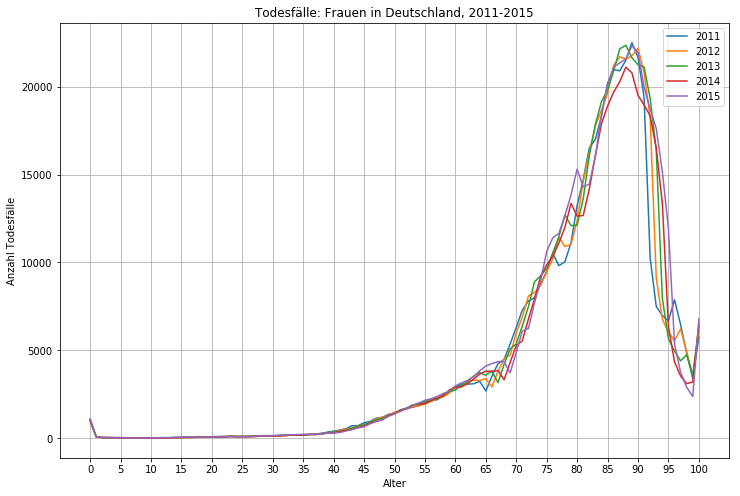

In [12]:
rohdaten_plot('f')

## "Optische" Auffälligkeiten

Rein "optisch": Bis zum Pensionsalter wenig Unterschiede, danach anscheinend "Verschiebung" der "lokalen Maxima" nach "oben rechts".

### Erste Differenzen

Sehr salopp gesagt: "Differenzieren verstärkt Schwankungen, Integrieren glättet Schwankungen aus."

In [13]:
# Wir bilden die ersten Differenzen
GMD_DIFF = pd.DataFrame(GMD[1:].values - GMD[:-1].values, columns=COLUMNS)
GFD_DIFF = pd.DataFrame(GFD[1:].values - GFD[:-1].values, columns=COLUMNS)
# Wir berücksichtigen diese neuen Daten in unserer "Daten-Buchhaltung"
DATEN['m']['delta'] = GMD_DIFF
DATEN['f']['delta'] = GFD_DIFF

In [14]:
# Eine Hilfsfunktion zum Plotten der Differenzen:
def diff_rohdaten_plot(gender):
    """Hilfsfunktion: Plot der ersten Differenzen der Todesfall-Rohdaten für Männer ('m') oder Frauen ('f')"""
    myplot = DATEN[gender]['delta'].plot(
        title=f'1. Differenzen Todesfälle: {DATEN[gender]["bez"]} in Deutschland, 2011-2015', figsize=(12,8)
    )
    myplot.set_xlabel('Alter')
    myplot.set_ylabel('Delta Todesfälle')
    plt.xticks(np.arange(0, 101, 5))
    myplot.grid(b=True)
    plt.savefig(GRAPHPATH+f'delta_roh_{gender}.eps')
    return myplot

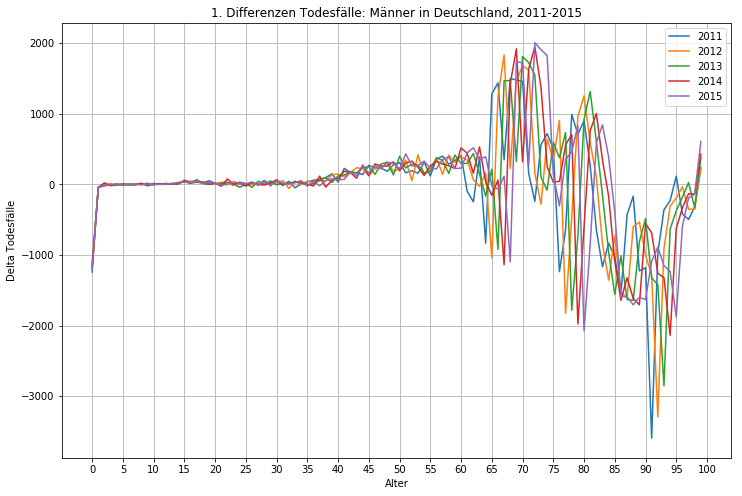

In [15]:
diff_rohdaten_plot('m')

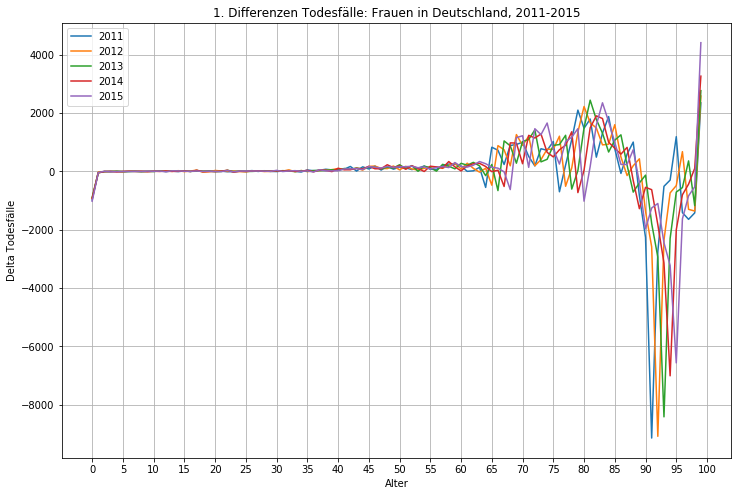

In [16]:
diff_rohdaten_plot('f')

wieder "rein optisch": Daten zeigen ab Alter etwa 65 deutlich anderes "qualitatives Verhalten".

In [17]:
# Eine Hilfsfunktion zum Plotten der Differenzen für einzelne Jahre:
def diff_rohdaten_plot_jahr(gender, years):
    """Hilfsfunktion: Plot der ersten Differenzen der Todesfall-Rohdaten für Männer ('m') oder Frauen ('f')"""
    fig, ax = plt.subplots(figsize=(12,8))
    for year in years:
        ax.plot(DATEN[gender]['delta'][year], label=f'{DATEN[gender]["bez"]} {year}')
    ax.legend(loc='lower left', shadow=True, fontsize='x-large')
    ax.set_title(f'1. Differenzen Todesfälle: {DATEN[gender]["bez"]} in Deutschland')
    ax.set_xlabel('Alter')
    ax.set_ylabel('Delta Todesfälle')
    plt.xticks(np.arange(0, 101, 5))
    ax.grid(b=True)
    plt.savefig(GRAPHPATH+f'delta_roh_{gender}_{years[0]}-{years[-1]}.eps')
    plt.show()

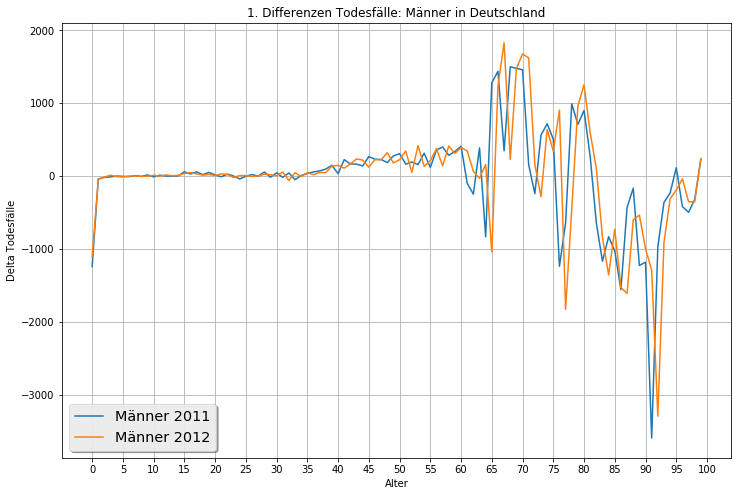

In [18]:
diff_rohdaten_plot_jahr('m', ['2011','2012'])

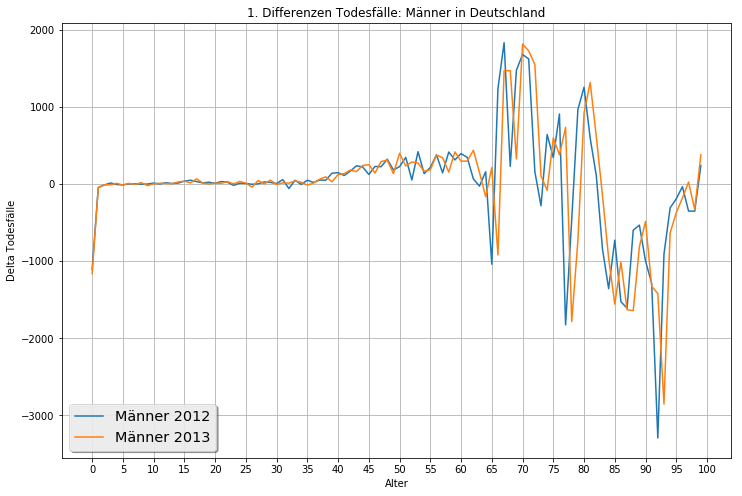

In [19]:
diff_rohdaten_plot_jahr('m', ['2012','2013'])

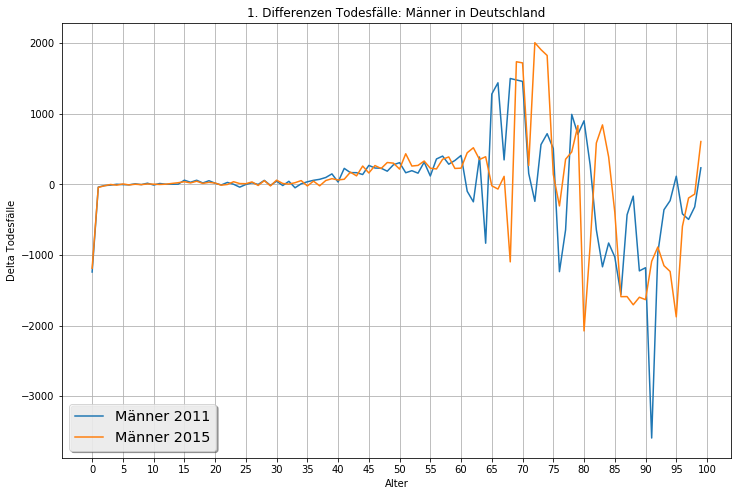

In [20]:
diff_rohdaten_plot_jahr('m', ['2011','2015'])

## "Ausglätten" mit Fourier-Transformation

Entwicklung eines Vektors nach einem vollständigen Orthonormalsystem in einem Hilbertraum.

In [21]:
# Eine Hilfsfunktion zum Plotten der Fourier-Anpassung:
def diff_fourier_plot(gender, year, start, k):
    """Hilfsfunktion: Plot der ersten Differenzen der Todesfall-Rohdaten für Männer ('m') oder Frauen ('f')"""
    data = DATEN[gender]['delta'][year][start:]
    
    # Gläten der Daten mit Fourier-Transformation in 3 Zeilen:
    fcoeffs = rfft(data) # Fourier-Transformation
    fcoeffs[k+1:] = 0.0 # Entfernen der hohen Frequenzen
    fitted_data = irfft(fcoeffs) # Inverse Fourier-Transformation
    
    # Formatierte Graphik
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(data.values, label='Rohdaten')
    ax.set_title(f'1. Differenzen Todesfälle {DATEN[gender]["bez"]} in {year}, ab Alter {start}')
    ax.plot(fitted_data, label=f'Fourier-Filter (k = {k})')
    ax.set_xlabel('Alter')
    ax.set_ylabel('Delta Todesfälle')
    legend = ax.legend(loc='lower left', shadow=True, fontsize='x-large')
    xticks_range = np.arange(0, 100 - start + 1, 5)
    labels = plt.xticks(xticks_range, xticks_range + start)
    ax.grid(b=True)
    plt.savefig(GRAPHPATH+f'ff_{gender}_{year}_{start}_{k}.eps')
    plt.show()
    return fcoeffs[:k]

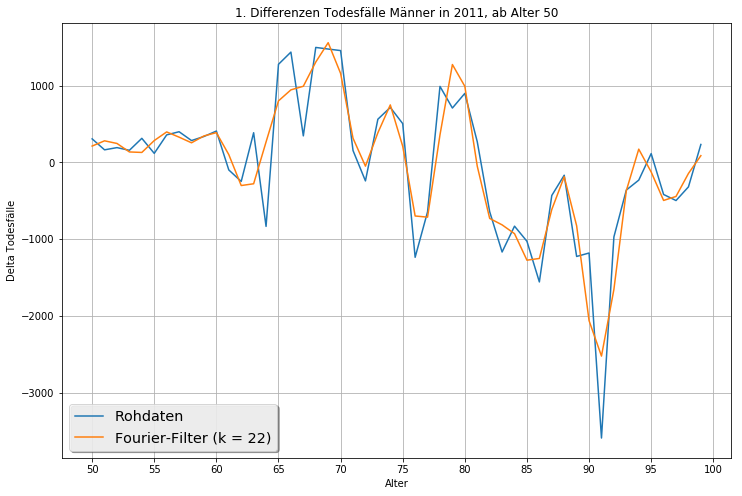

array([ -1833.        ,  -6324.26569887, -18542.51716558,   8632.55066957,
          300.02326563,   6433.12729325,    930.60478799,  -6350.99448648,
         -784.86364118,   1981.48173285,   6006.92128015,  -4205.09208169,
        -1852.81154131,   1519.75139494,  -9628.59378596,   5745.7366458 ,
         2546.25490113,   1602.73317576,    111.02727318,   2393.89328879,
         7638.34239506,  -5183.87956618])

In [22]:
diff_fourier_plot('m', '2011', 50, 22)

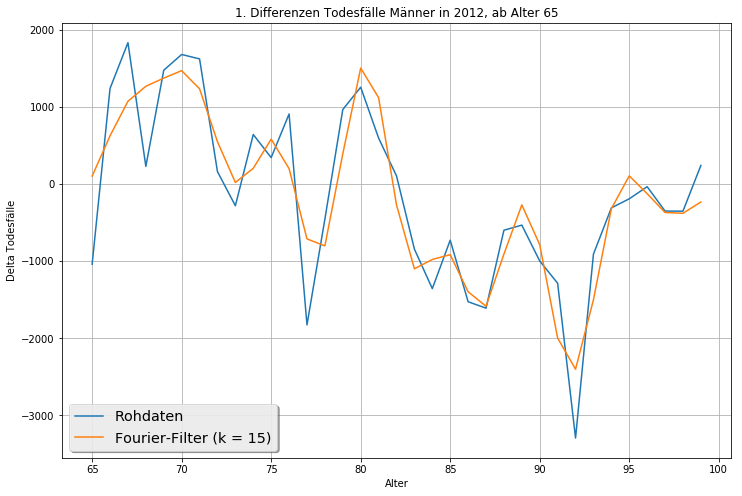

array([ -5279.        ,   7853.31250836, -16690.84543292,   5385.55048531,
        -1747.61985701,  -3629.46415686,  -4555.15811238,  -4246.04144582,
         4844.06224251,  -3871.44949694,  -7518.2353019 ,    739.033651  ,
          549.33081499,   7760.15404908,    666.0269004 ])

In [23]:
diff_fourier_plot('m', '2012', 65, 15)

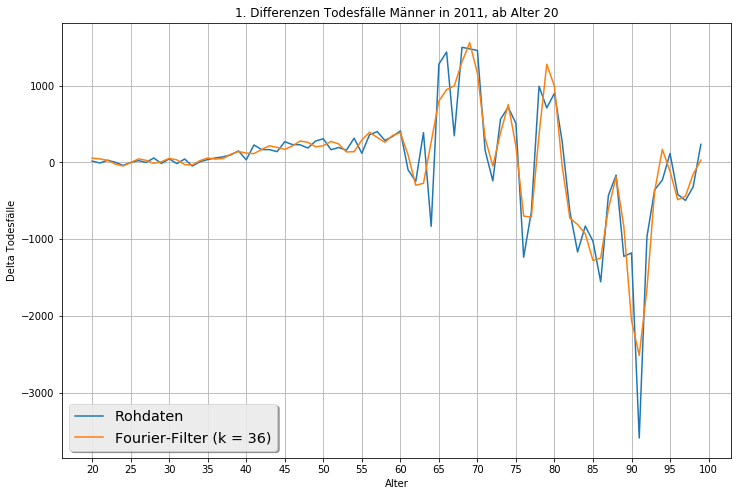

array([   578.        , -17742.08085282,  -7202.58484712,   2735.2368214 ,
       -15878.44456422,  11095.83271195,   -949.27757688,   2723.98316732,
          -19.26780535,   6164.66623605,   3606.37342618,  -5149.96605391,
         5793.01093569,    751.70321775,  -4878.08804726,   1978.37374886,
         6518.82558346,  -5718.58911195,    555.81343524,  -4596.16907835,
        -2422.98581978,   -930.60822403,  -9166.80247325,   8186.86021618,
        -3807.94099742,   4320.10715681,   3221.97997845,    956.43676993,
         1272.69303309,   3828.44226761,    512.79742477,   2306.13593457,
         7599.74032625,  -8367.93522259,   2719.96628708,   -642.97964308])

In [24]:
diff_fourier_plot('m', '2011', 20, 36)

## Von Rohdaten zu Sterbewahrscheinlichkeiten

### Ohne Berücksichtigung der "zeitlichen Entwicklung"

Natürlich kann man den Mittelwert der Todesfälle im x-ten Lebensjahr für die 5 Jahre 2011-2015 betrachten:

In [26]:
AGGREGIERT = pd.DataFrame(
    np.array([list(GMD.mean(axis=1).values), list(GFD.mean(axis=1).values)]).T, 
    columns=['Männer', 'Frauen']
)

In [27]:
AGGREGIERT.head()

Männer  Frauen
0  1277.0  1032.8
1    99.6    81.4
2    55.6    42.4
3    47.2    38.8
4    40.6    32.8

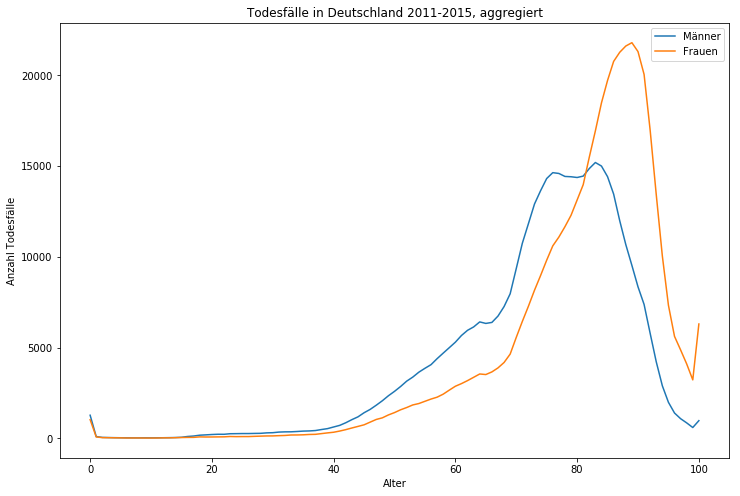

In [28]:
myplot = AGGREGIERT.plot(title='Todesfälle in Deutschland 2011-2015, aggregiert', figsize=(12,8))
myplot.set_xlabel('Alter')
myplot.set_ylabel('Anzahl Todesfälle')
plt.savefig(DATAPATH+'aggregiert.eps')
myplot

## NUR FÜR ILLUSTRATIONSZWECKE (An sich _unzulässige_ Annahme!)

Es fehlen hier die Informationen, _wieviele_ x-Jährige durch die Todesfälle im x-ten Lebensjahr dezimiert wurden, es ist also _nicht möglich_, die Sterbewahrscheinlichkeiten
$$q_x\sim\frac{\text{im x-ten Jahr Verstorbene}}{\text{x-Jährige}}$$
ohne weiteres aus den Daten zu schätzen.

Um dennoch weiterzumachen (es geht hier ja um die _Illustration_ von Software-Tools), fasse ich die vorliegenden Zahlen als erste Differenzen einer Ausscheideordnung auf (mit "Startwert" gleich der Summe über _alle_ Todesfälle):

(Bei der sachlich richtigen Vorgangsweise mit Kohortensterbetafeln müßten die Wanderungssalden berücksichtig werden, siehe Kohortensterbetafeln
für Deutschland/destatis).

In [29]:
AOM = np.r_[GMD.sum(axis=1).values[::-1].cumsum()[::-1], np.zeros(1)]
AOM = 10**6 / AOM[0] * AOM
AOF = np.r_[GFD.sum(axis=1).values[::-1].cumsum()[::-1], np.zeros(1)]
AOF = 10**6 / AOF[0] * AOF

In [30]:
AO_AGGREGIERT = pd.DataFrame(
    np.array([AOM, AOF]).T,
    columns=['Männer', 'Frauen']
)

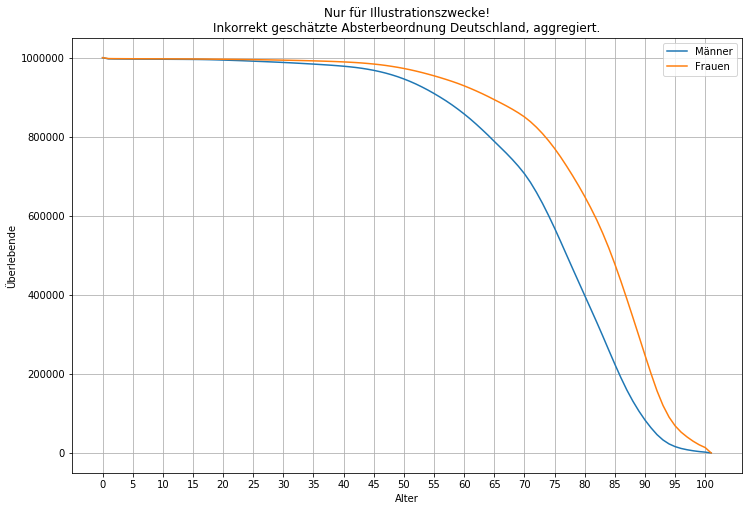

In [31]:
myplot = AO_AGGREGIERT.plot(title='Nur für Illustrationszwecke!\nInkorrekt geschätzte Absterbeordnung Deutschland, aggregiert.', figsize=(12,8))
myplot.set_xlabel('Alter')
myplot.set_ylabel('Überlebende')
plt.xticks(np.arange(0, 101, 5))
myplot.grid(b=True)
plt.savefig(GRAPHPATH+'ao_aggregiert.eps')
myplot

In [35]:
GMD_SUMS = dict(zip(GMD.columns, [GMD[column].sum() for column in GMD.columns]))
GFD_SUMS = dict(zip(GFD.columns, [GFD[column].sum() for column in GFD.columns]))

In [36]:
GMD_AO=pd.DataFrame(
    np.array([np.r_[GMD[column].values[::-1].cumsum()[::-1]/GMD_SUMS[column]*(10**6), np.zeros(1)] for column in GMD.columns]).T,
    columns = GMD.columns
)
GFD_AO=pd.DataFrame(
    np.array([np.r_[GFD[column].values[::-1].cumsum()[::-1]/GFD_SUMS[column]*(10**6), np.zeros(1)] for column in GFD.columns]).T,
    columns = GFD.columns
)
DATEN['m']['ao'] = GMD_AO
DATEN['f']['ao'] = GFD_AO

In [37]:
# Eine Hilfsfunktion zum Plotten der - sehr ungenau geschätzten! - Absterbeordnung:
def ao_plot(gender):
    """Hilfsfunktion: Plot der sehr ungenau geschätzten Absterbeordnung für Männer ('m') oder Frauen ('f')"""
    myplot = DATEN[gender]['ao'].plot(
        title=f'Nur für Illustrationszwecke!\nInkorrekt geschätzte Absterbeordnung: {DATEN[gender]["bez"]} in Deutschland, 2011-2015.', figsize=(12,8)
    )
    myplot.set_xlabel('Alter')
    myplot.set_ylabel('Überlebende')
    plt.xticks(np.arange(0, 101, 5))
    myplot.grid(b=True)
    plt.savefig(GRAPHPATH+f'ao_{gender}.eps')
    return myplot

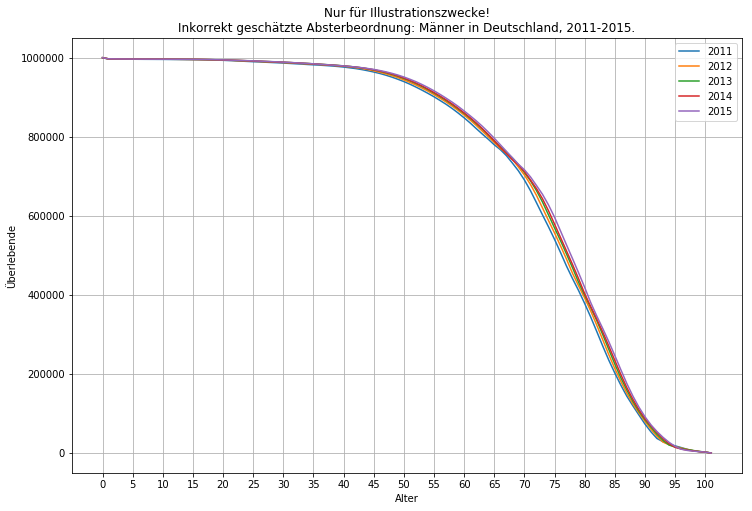

In [38]:
ao_plot('m')

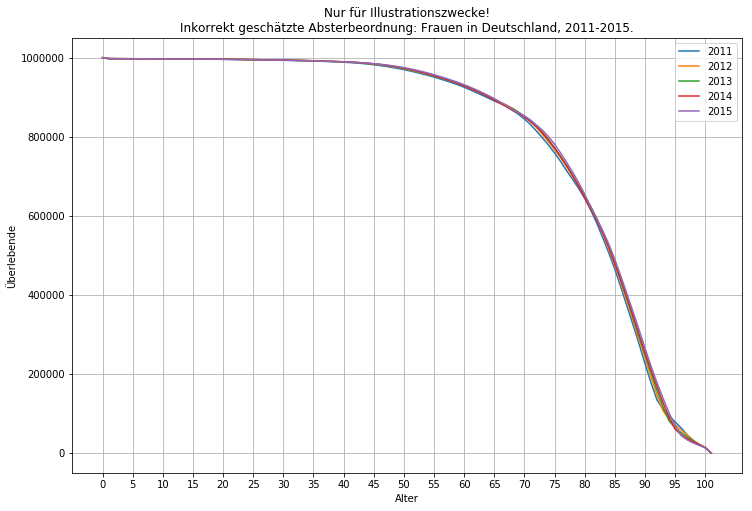

In [39]:
ao_plot('f')

### Sensitivitätsanalysen

Welche Unterschiede ergeben sich in den versicherungsmathematischen Barwerten, wenn man die 5 verschiedenen (nur für Illustrationszwecke geschätzten!!!) Sterbetafeln 2011-2015 betrachtet?

In [40]:
def actuarial_pv(x, ao, rz):
    """Barwert einer lebenslänglichen nachschüssigen Leibrente ab Alter x"""
    survival_probabilities = ao[x+1:]/ao[x]
    discount_factors = np.array([(1+rz/100) ** (-t) for t in range(1, len(ao) - x)])
    return np.inner(survival_probabilities, discount_factors) 

In [41]:
actuarial_pv(20, GMD_AO['2011'], 1.5)

36.07104471842042

In [131]:
def sensitivity_plot(gender, rz):
    """Sehr einfache Sensitivitätsanalyse"""
    ao = DATEN[gender]['ao']
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    for colour, x in zip(['r', 'g', 'b', 'y', 'c', 'magenta'], [20, 30, 40, 50, 60, 70]):
        xs = range(5)
        ys = np.array([actuarial_pv(x, ao[year], rz) for year in COLUMNS])
        ref_value = ys[0]
        ys = (ys - ref_value)/ref_value * 100
        cs = [colour] * len(xs)
        ax.bar(xs, ys, zs=x, zdir='y', color=cs, alpha=0.8)
    # ax.set_xlabel('X')
    ax.set_title(f'Nur für Illustrationszwecke!\nRelative Barwert-Änderungen (in %) im Vergleich zu 2011,\n{DATEN[gender]["bez"]} bei Rechnungszins {rz}%')
    ax.set_ylabel('Alter x')
    ax.set_zlabel('Delta Barwerte (%)')
    plt.xticks(np.arange(5), COLUMNS)
    plt.savefig(GRAPHPATH+f'sens_{gender}_{rz}.pdf')

    plt.show()

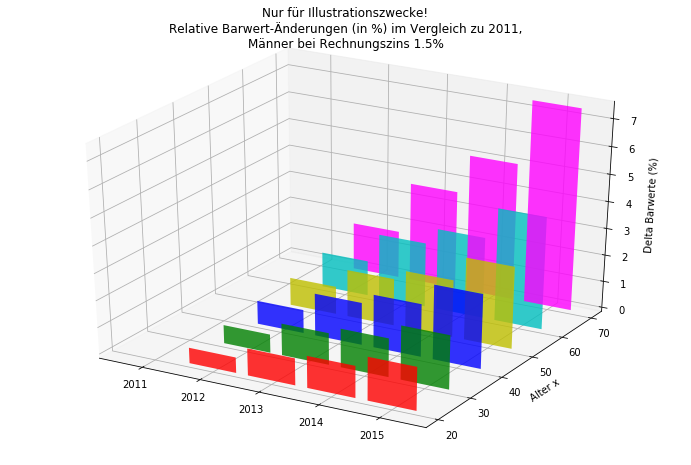

In [132]:
sensitivity_plot('m', 1.5)

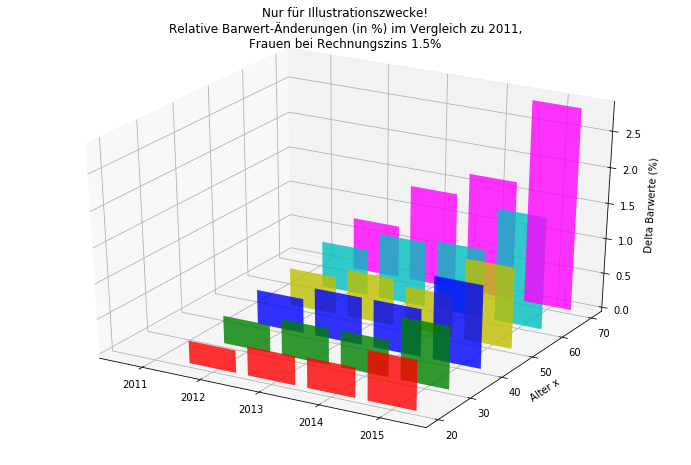

In [133]:
sensitivity_plot('f', 1.5)

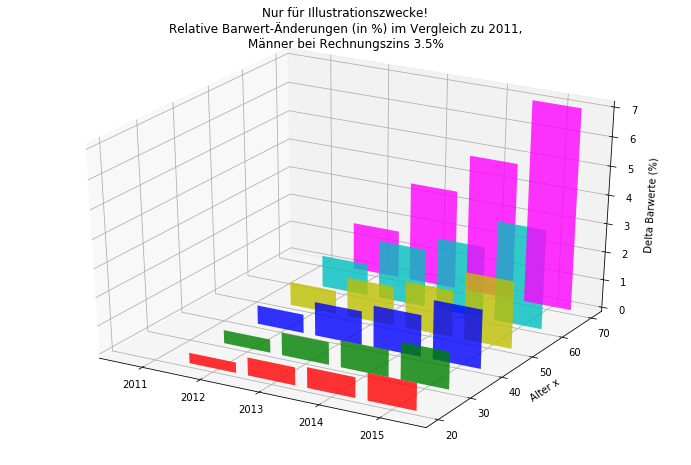

In [47]:
sensitivity_plot('m', 3.5)

### Risken auf der Passivseite: Value-at-Risk mit Monte-Carlo-Simulation

Die klassische versicherungsmathematische Modellierung von biometrischen Risiken ist eigentlich sehr einfach:

* Bestimme der Erwartungswert der Leistungen
* (und verlasse Dich auf das Gesetz der großen Zahlen).

Tatsächlich kann man mit geringem Aufwand etwas mehr Information gewinnen:

In [111]:
def mc_actuarial_pv(x, ao, rz, nof_persons, nof_scen):
    """Monte-Carlo-Simulation: Barwert einer lebenslänglichen nachschüssigen Leibrente ab Alter x"""
    # Wahrscheinlichkeiten, das (x+k)-te Lebensjahr _nicht_ zu erreichen, für k = 1,2,3, ...
    probabilities = np.array(1.0 - ao[x+1:]/ao[x])
    # Rein finanzmathematische Barwerte von k jährlichen Zahlungen der Höhe 1, für k = 1,2,3, ...
    pv = np.cumsum(np.array([0.0]+[(1+rz/100) ** (-t) for t in range(1, len(probabilities)+1)]))
    # Erzeuge nof_scen gleichverteilte (Pseudo-)Zufallszahlen
    scenarios = uniform.rvs(size=nof_scen*nof_persons)
    # Simuliere nof_scen-mal eine Risikogemeinschaft von nof_persons x-Jährigen
    # und bestimme die mittlere Auszahlung einer Leibrente der Höhe 1 für jedes Szenario
    return np.sort(
        np.mean(
            np.array([pv[np.searchsorted(probabilities, s)] for s in scenarios]).reshape((nof_scen, nof_persons)),
            axis=(1,)
        )
    )

In [121]:
mc_actuarial_pv(20, DATEN['m']['ao']['2011'], 1.5, 10, 100)

array([29.48076713, 31.20840731, 31.62827396, 32.17955738, 32.46316356,
       32.61938358, 33.32657374, 33.36306337, 33.58262661, 33.68519852,
       33.7349793 , 33.9459774 , 34.17347791, 34.44457781, 34.4671579 ,
       34.53777806, 34.55044801, 34.56731018, 34.63805697, 34.76127372,
       34.76190071, 34.81641926, 34.81727949, 34.8789503 , 34.87971956,
       34.93713912, 34.96557308, 35.00554834, 35.17693516, 35.17719217,
       35.62196624, 35.63186883, 35.83502833, 35.84540509, 35.85134884,
       35.89037549, 35.90543508, 35.92891912, 35.94719072, 35.97135575,
       36.08730989, 36.10063722, 36.10932842, 36.16829582, 36.20532615,
       36.34188968, 36.4545073 , 36.48764963, 36.50352075, 36.57103829,
       36.62216901, 36.64192145, 36.64691687, 36.66129488, 36.72889993,
       36.75637281, 36.82332686, 36.92362099, 36.94282925, 37.01652166,
       37.0304128 , 37.1154399 , 37.12050154, 37.12434508, 37.19588924,
       37.2319222 , 37.2449988 , 37.32647013, 37.34506058, 37.38

In [113]:
# Erwarteter Barwert:
actuarial_pv(20, DATEN['m']['ao']['2011'], 1.5)

36.07104471842042

In [122]:
# "Versicherungstechnische" Gewinnne/Verluste
def guv(x, ao, rz, nof_persons, nof_scens):
    """Bestimme GuV-Vektor als Differenz von vers.math. Barwert und simulierten Auszahlungen"""
    return mc_actuarial_pv(x, ao, rz, nof_persons, nof_scens) - actuarial_pv(x, ao, rz)

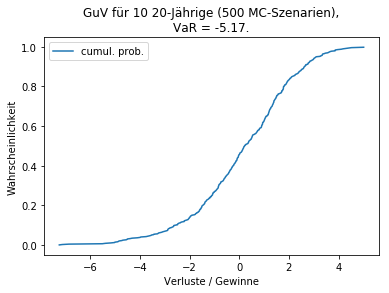

In [134]:
def plot_risk_profile(x, ao, rz, nof_persons, nof_scens):
    """Plot von Monte-Carlo-Simulierten versicherungstechnischen Verlusten/Gewinnen"""
    # Bestimme GuV-Vektor
    guv_vector = guv(x, ao, rz, nof_persons, nof_scens)
    # Bestimme (empirische) Wahrscheinlichkeitsverteilung
    v_len = len(guv_vector)
    cumul_probs = np.array([p/v_len for p in range(v_len)])
    risk_profile = pd.DataFrame(cumul_probs, index=guv_vector, columns=['cumul. prob.'])
    # Bestimme das 1%-Quantil (Value at Risk)
    VaR = guv_vector[nof_scens // 100]
    # Plot der Wahrscheinlichkeitsverteilung
    myplot = risk_profile.plot()
    myplot.set_xlabel('Verluste / Gewinne')
    myplot.set_ylabel('Wahrscheinlichkeit')
    myplot.set_title(f'GuV für {nof_persons} {x}-Jährige ({nof_scens} MC-Szenarien),\nVaR = {VaR:3.3}.')
    plt.savefig(GRAPHPATH+f'mc_{nof_persons}_{x}_{nof_scens}.eps')


    # return guv_vector

plot_risk_profile(20, DATEN['m']['ao']['2011'], 1.5, 10, 500)

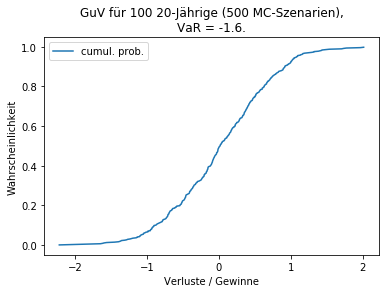

In [135]:
plot_risk_profile(20, DATEN['m']['ao']['2011'], 1.5, 100, 500)

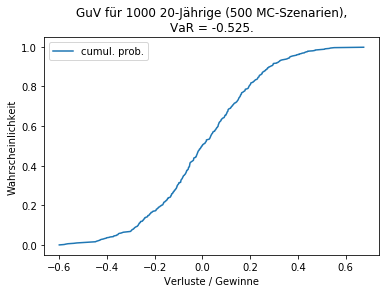

In [136]:
plot_risk_profile(20, DATEN['m']['ao']['2011'], 1.5, 1000, 500)

## k-Means - "unsupervised learning"

Ein bißchen weit hergeholt: Die Unterscheidung bei den Todesfällen in die Gruppen "0-60" Jahre und "61-100 Jahre" (siehe Fourier-Transformation) kann man als "Clustering von Datenwolken" interpretieren.

In [456]:
# xls_writer = pd.ExcelWriter(DATAPATH+'dummydaten.xlsx')

### 3-D

In [459]:
# Erzeuge dreidimensionale Zufalls-Daten
NOF_POINTS = [400, 500, 450]
SHIFT = np.array([65, 7, 9])
MEAN1 = np.array([1,0,0])*2 + SHIFT
MEAN2 = np.array([0,1,0])*2 + SHIFT
MEAN3 = np.array([0,0,1])*2 + SHIFT
COV1 = np.array([
    [1.0, 0.5, -0.6],
    [0.5, 2.0, -0.2],
    [-0.6,-0.2, 3.0]
])/10
COV2 = np.array([
    [3.0, 0.5, -0.6],
    [0.5, 2.0, -0.2],
    [-0.6,-0.2, 1.0]
])/10
COV3 = np.array([
    [2.0, 0.5, -0.6],
    [0.5, 2.0, -0.2],
    [-0.6,-0.2, 2.0]
])/10
dummy = np.concatenate(
    ((np.random.multivariate_normal(MEAN1, COV1, NOF_POINTS[0])),
     (np.random.multivariate_normal(MEAN2, COV2, NOF_POINTS[1])),
     (np.random.multivariate_normal(MEAN3, COV3, NOF_POINTS[2]))
    ),
    axis=0
)
dummydf = pd.DataFrame(dummy, columns=['Alter', 'Vertragsdauer', 'Rating'])
dummydf.head()

Alter  Vertragsdauer    Rating
0  67.051335       7.203385  8.925877
1  66.996607       7.284467  9.340006
2  66.671422       6.522801  9.610868
3  67.286388       7.084855  9.010977
4  66.819989       7.357022  9.280727

In [461]:
# dummydf.to_excel(xls_writer, sheet_name='Dummy 3D', index_label="Nr.", freeze_panes=(1,1))

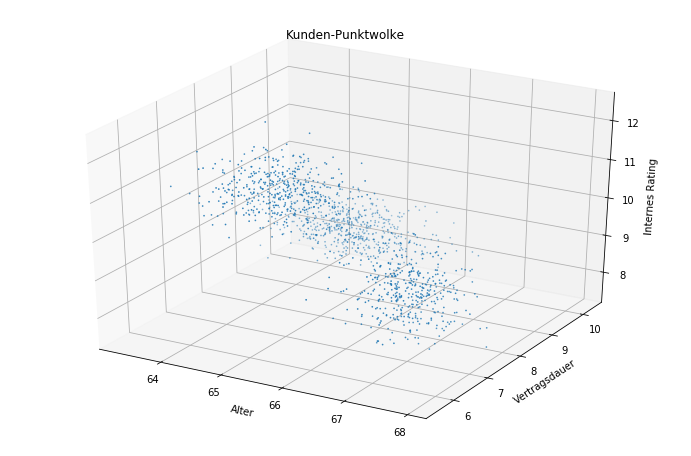

In [462]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dummy.T[0], dummy.T[1], dummy.T[2], s = 0.5)
ax.set_title('Kunden-Punktwolke')
ax.set_xlabel('Alter')
ax.set_ylabel('Vertragsdauer')
ax.set_zlabel('Internes Rating')
plt.savefig(GRAPHPATH+'Punktwolke3D.eps')
plt.show()

In [463]:
dummy = scale_this(dummy)
centroids = kmeans(dummy, 3)[0]
centroids

array([[ 1.28389385, -0.86324932, -0.41525212],
       [-0.62263851,  0.24905567,  0.32026217],
       [ 1.34837899, -0.01481531, -1.06125911]])

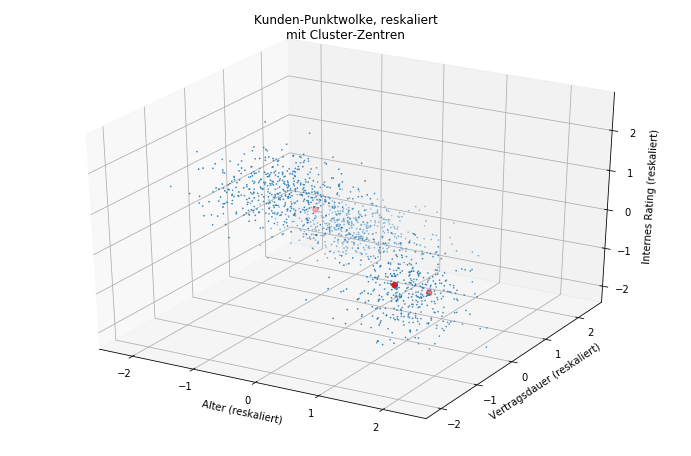

In [464]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dummy.T[0], dummy.T[1], dummy.T[2], s=0.5)
ax.set_title('Kunden-Punktwolke, reskaliert\nmit Cluster-Zentren')
ax.scatter(centroids.T[0], centroids.T[1], centroids.T[2], s=30.0, c='red')
ax.set_xlabel('Alter (reskaliert)')
ax.set_ylabel('Vertragsdauer (reskaliert)')
ax.set_zlabel('Internes Rating (reskaliert)')
plt.savefig(GRAPHPATH+'Punktwolke3D_rescaled.eps')
plt.show()

Auch in "nur" drei Dimensionen wird die Visualisierung schon schwieriger.

### 2-D

In [44]:
# Erzeuge zweidimensionale Zufalls-Daten
NOF_POINTS = [3000, 5000, 5500, 3000]
SHIFT = np.array([62, 14])
MEAN1 = np.array([3,0])*0.95 + SHIFT
MEAN2 = np.array([0,1])*0.95 + SHIFT
MEAN3 = np.array([0,0]) + SHIFT
MEAN4 = np.array([3,1]) + SHIFT

COV1 = np.array([
    [4.0, 0.5],
    [0.5, 1.0]
])/6
COV2 = np.array([
    [3.0, 0.5],
    [0.5, 1.0]
])/6
COV3 = np.array([
    [1.0, -0.5],
    [-0.5, 1.0]
])/6
COV4 = np.array([
    [3.0, -0.2],
    [-0.2, 0.7]
])/6
dummy = np.concatenate(
    ((np.random.multivariate_normal(MEAN1, COV1, NOF_POINTS[0])),
     (np.random.multivariate_normal(MEAN2, COV2, NOF_POINTS[1])),
     (np.random.multivariate_normal(MEAN3, COV3, NOF_POINTS[2])),
     (np.random.multivariate_normal(MEAN4, COV4, NOF_POINTS[3]))
    ),
    axis=0
)
dummydf = pd.DataFrame(dummy, columns=['Alter', 'Rating'])
dummydf.head()

Alter     Rating
0  65.019132  14.116631
1  65.887631  14.857895
2  64.880394  14.246773
3  64.303667  13.872703
4  64.965886  14.256922

In [466]:
# dummydf.to_excel(xls_writer, sheet_name='Dummy 2D', index_label="Nr.", freeze_panes=(1,1))

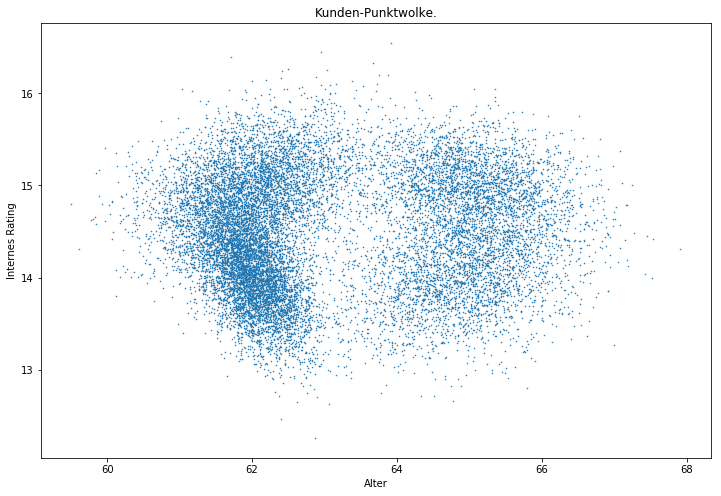

In [45]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(dummy.T[0], dummy.T[1], s=0.3)
ax.set_title('Kunden-Punktwolke.')
ax.set_xlabel('Alter')
ax.set_ylabel('Internes Rating')
plt.savefig(GRAPHPATH+'Punktwolke2D.eps')

In [46]:
dummy = scale_this(dummy)

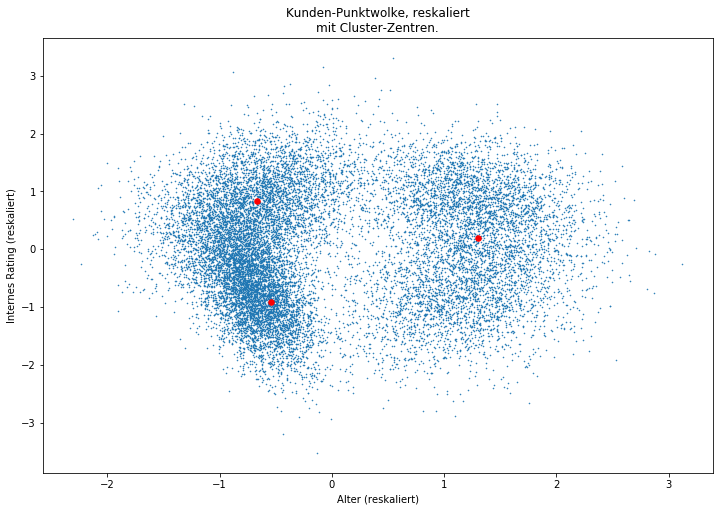

In [49]:
centroids = kmeans(dummy, 3)[0]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(dummy.T[0], dummy.T[1], s=0.3)
ax.scatter(centroids.T[0], centroids.T[1], s=30.0, c='red')
ax.set_title('Kunden-Punktwolke, reskaliert\nmit Cluster-Zentren.')
ax.set_xlabel('Alter (reskaliert)')
ax.set_ylabel('Internes Rating (reskaliert)')
plt.savefig(GRAPHPATH+'Punktwolke2D_rescaled_3.eps')

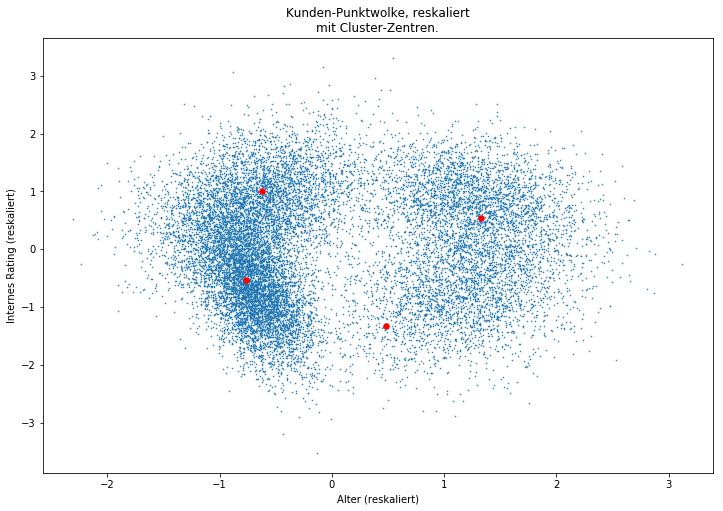

In [48]:
centroids = kmeans(dummy, 4)[0]
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(dummy.T[0], dummy.T[1], s=0.3)
ax.scatter(centroids.T[0], centroids.T[1], s=30.0, c='red')
ax.set_title('Kunden-Punktwolke, reskaliert\nmit Cluster-Zentren.')
ax.set_xlabel('Alter (reskaliert)')
ax.set_ylabel('Internes Rating (reskaliert)')
plt.savefig(GRAPHPATH+'Punktwolke2D_rescaled_4.eps')

In [471]:
# xls_writer.save()

## Ausblick

Machine learning, deep learning ("neural networks"): Zum Teil ausgereifte Software-Bibliotheken vorhanden,
mit entsprechendem Hintergrundwissen und etwas Programmierkenntnissen ist es also relativ leicht möglich,
Datenanalyse-Projekte umzusetzen.